<a href="https://colab.research.google.com/github/yfb2022/Project-101/blob/main/CV_%EB%AC%B4%EC%8B%A0%EC%82%AC_%EC%9D%98%EB%A5%98%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# CALL #
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.resnet50 import ResNet50
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import load_img 
from tensorflow.keras.utils import img_to_array 
from keras.applications.vgg16 import preprocess_input 
from glob import glob
from pathlib import Path
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data_dir = "/content/drive/MyDrive/의류"

# 배치 사이즈 및 이미지 크기 고정
batch_size = 32 
img_height = 224 
img_width = 224 

# 훈련, 검증 데이터 셋 제작 (8:2) 
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  label_mode='categorical',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  label_mode = 'categorical',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# 클래스 이름 추출 (바지, 아우터, 상의, 신발)
class_names = train_ds.class_names
print(class_names)

# 훈련 데이터 셋 배치 출력 (18분 걸림, (32,180,180,3))
# for image_batch, labels_batch in train_ds:
#   print(image_batch.shape)
#   print(labels_batch.shape)

Found 8479 files belonging to 4 classes.
Using 6784 files for training.
Found 8479 files belonging to 4 classes.
Using 1695 files for validation.
['바지', '상의', '신발', '아우터']


/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 4359 (\N{HANGUL CHOSEONG PIEUP}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 4449 (\N{HANGUL JUNGSEONG A}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 4364 (\N{HANGUL CHOSEONG CIEUC}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 4469 (\N{HANGUL JUNGSEONG I}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 4361 (\N{HANGUL CHOSEONG SIOS}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 4523 (\N{HANGUL JONGSEONG NIEUN}) missing from current font.
  func(*ar

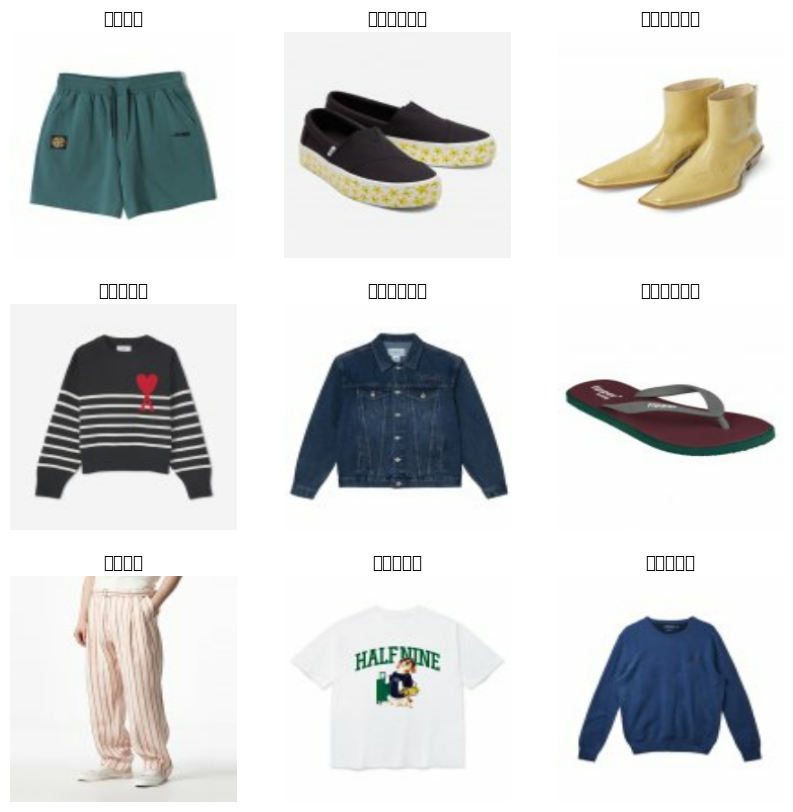

In [ ]:
# 훈련 데이터셋 시각화화
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
# 데이터 입력 파이프라인 (병렬처리, 작업시간 단축)
# https://www.tensorflow.org/guide/data_performance?hl=ko
AUTOTUNE = tf.data.experimental.AUTOTUNE #

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# BASELINE MODEL 1 (REFERENCED)

In [ ]:
# Baseline Model
model1 = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(224, 224, 3)),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D((2,2)),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D((2,2)),
  layers.Conv2D(64, 3, activation='relu'),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(4, activation='softmax')])

model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 52, 52, 64)       

In [ ]:
# Back Propagation (ADAM), 모델학습, 검증 데이터셋 정확도
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model1.fit(train_ds, validation_data=val_ds, epochs=10)

model1.evaluate(val_ds)

Epoch 1/10
212/212 [==============================] - 407s 2s/step - loss: 0.8303 - accuracy: 0.6812 - val_loss: 0.5186 - val_accuracy: 0.7923
Epoch 2/10
212/212 [==============================] - 19s 87ms/step - loss: 0.4369 - accuracy: 0.8364 - val_loss: 0.4960 - val_accuracy: 0.8336
Epoch 3/10
212/212 [==============================] - 23s 109ms/step - loss: 0.3186 - accuracy: 0.8788 - val_loss: 0.3536 - val_accuracy: 0.8755
Epoch 4/10
212/212 [==============================] - 19s 86ms/step - loss: 0.2448 - accuracy: 0.9061 - val_loss: 0.3223 - val_accuracy: 0.8861
Epoch 5/10
212/212 [==============================] - 20s 91ms/step - loss: 0.1729 - accuracy: 0.9368 - val_loss: 0.3610 - val_accuracy: 0.8861
Epoch 6/10
212/212 [==============================] - 18s 85ms/step - loss: 0.1327 - accuracy: 0.9503 - val_loss: 0.4976 - val_accuracy: 0.8649
Epoch 7/10
212/212 [==============================] - 18s 85ms/step - loss: 0.0922 - accuracy: 0.9658 - val_loss: 0.4132 - val_accuracy:

[0.58419269323349, 0.8908554315567017]

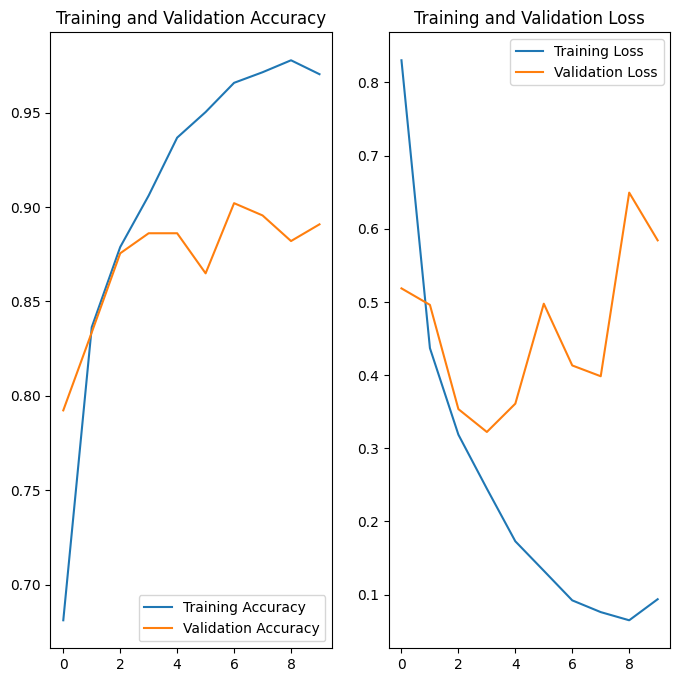

In [ ]:
# Result: Accuracy, Loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss= history.history['loss']
val_loss= history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# DEVELOPED MODEL2

In [ ]:
# Model3
model2 = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(224, 224, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D((2,2)),
  layers.BatchNormalization(),
  layers.Dropout(0.25),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D((2,2)),
  layers.BatchNormalization(),
  layers.Dropout(0.25),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D((2,2)),
  layers.BatchNormalization(),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(256, activation = 'relu'),
  layers.Dense(128, activation = 'relu'),
  layers.Dense(4, activation = 'softmax'),
])

model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 112, 112, 32)     128       
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 112, 112, 32)      0         
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 32)     

In [ ]:
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history2 = model2.fit(train_ds, validation_data=val_ds, epochs=15)

model2.evaluate(val_ds)

Epoch 1/15
212/212 [==============================] - 30s 49ms/step - loss: 0.9977 - accuracy: 0.7298 - val_loss: 2.6237 - val_accuracy: 0.3782
Epoch 2/15
212/212 [==============================] - 7s 31ms/step - loss: 0.3650 - accuracy: 0.8601 - val_loss: 1.0311 - val_accuracy: 0.6791
Epoch 3/15
212/212 [==============================] - 7s 31ms/step - loss: 0.2552 - accuracy: 0.8992 - val_loss: 0.5764 - val_accuracy: 0.8419
Epoch 4/15
212/212 [==============================] - 7s 34ms/step - loss: 0.2227 - accuracy: 0.9155 - val_loss: 0.9063 - val_accuracy: 0.7575
Epoch 5/15
212/212 [==============================] - 6s 30ms/step - loss: 0.1580 - accuracy: 0.9369 - val_loss: 0.3689 - val_accuracy: 0.8814
Epoch 6/15
212/212 [==============================] - 7s 31ms/step - loss: 0.0956 - accuracy: 0.9606 - val_loss: 0.7155 - val_accuracy: 0.8006
Epoch 7/15
212/212 [==============================] - 6s 30ms/step - loss: 0.0902 - accuracy: 0.9673 - val_loss: 1.0934 - val_accuracy: 0.766

[0.43325331807136536, 0.9162241816520691]

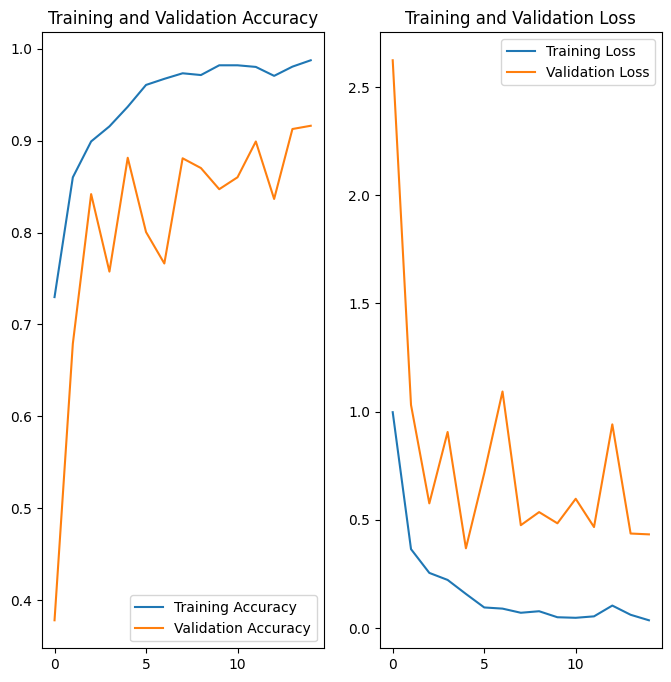

In [ ]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss= history2.history['loss']
val_loss= history2.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# MY MODEL

In [ ]:
model4 = Sequential()
model4.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', 
                    activation ='relu', input_shape = (180, 180, 3)))

model4.add(MaxPooling2D(pool_size=(2,2), strides=2))

model4.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Valid', 
                    activation ='relu'))

model4.add(MaxPooling2D(pool_size=(2,2), strides=2))

model4.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Valid', 
                    activation ='relu'))

model4.add(MaxPooling2D(pool_size=(2,2), strides=2))

model4.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Valid', 
                    activation ='relu'))

model4.add(MaxPooling2D(pool_size=(2,2), strides=2))

model4.add(Flatten())

model4.add(Dense(512, activation = "relu"))

model4.add(Dense(4, activation = "softmax"))
model4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 88, 88, 16)        2320      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 44, 44, 16)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 40, 40, 32)        12832     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 20, 20, 32)      

In [ ]:
model4.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history4 = model4.fit(train_ds, validation_data=val_ds, epochs=10)

model4.evaluate(val_ds)

Epoch 1/10
212/212 [==============================] - 19s 26ms/step - loss: 1.9041 - accuracy: 0.6523 - val_loss: 0.5703 - val_accuracy: 0.7947
Epoch 2/10
212/212 [==============================] - 3s 13ms/step - loss: 0.4942 - accuracy: 0.8227 - val_loss: 0.5455 - val_accuracy: 0.7971
Epoch 3/10
212/212 [==============================] - 3s 13ms/step - loss: 0.3965 - accuracy: 0.8530 - val_loss: 0.5054 - val_accuracy: 0.8201
Epoch 4/10
212/212 [==============================] - 3s 13ms/step - loss: 0.3088 - accuracy: 0.8869 - val_loss: 0.3649 - val_accuracy: 0.8726
Epoch 5/10
212/212 [==============================] - 3s 16ms/step - loss: 0.2736 - accuracy: 0.8959 - val_loss: 0.4352 - val_accuracy: 0.8437
Epoch 6/10
212/212 [==============================] - 3s 13ms/step - loss: 0.2544 - accuracy: 0.9020 - val_loss: 0.3547 - val_accuracy: 0.8773
Epoch 7/10
212/212 [==============================] - 3s 12ms/step - loss: 0.2195 - accuracy: 0.9154 - val_loss: 0.3613 - val_accuracy: 0.882

[0.49723464250564575, 0.8607669472694397]

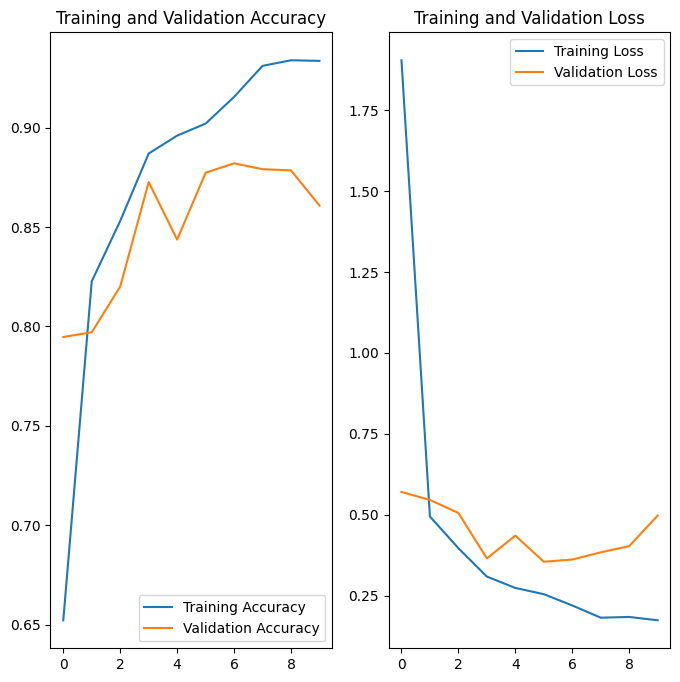

In [ ]:
acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']

loss= history4.history['loss']
val_loss= history4.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Transfer Learning

In [ ]:
resnet = ResNet50(weights='imagenet', include_top=False,
                  input_shape = (224, 224, 3))

resnet.trainable = False


res_model = tf.keras.Sequential([
    resnet,
    GlobalAveragePooling2D(),
    Dense(128, activation = 'relu'),
    Dropout(0.5),
    Dense(4, activation = 'softmax')
])

res_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 23,850,500
Trainable params: 262,788
Non-trainable params: 23,587,712
______________________________________

In [ ]:
res_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

rhistory = res_model.fit(train_ds, validation_data=val_ds, epochs=10)

res_model.evaluate(val_ds)

Epoch 1/10
212/212 [==============================] - 160s 571ms/step - loss: 0.2877 - accuracy: 0.8797 - val_loss: 0.1837 - val_accuracy: 0.9227
Epoch 2/10
212/212 [==============================] - 24s 114ms/step - loss: 0.1937 - accuracy: 0.9223 - val_loss: 0.1617 - val_accuracy: 0.9375
Epoch 3/10
212/212 [==============================] - 24s 114ms/step - loss: 0.1687 - accuracy: 0.9300 - val_loss: 0.1552 - val_accuracy: 0.9410
Epoch 4/10
212/212 [==============================] - 25s 116ms/step - loss: 0.1533 - accuracy: 0.9384 - val_loss: 0.1513 - val_accuracy: 0.9381
Epoch 5/10
212/212 [==============================] - 25s 117ms/step - loss: 0.1397 - accuracy: 0.9452 - val_loss: 0.1397 - val_accuracy: 0.9440
Epoch 6/10
212/212 [==============================] - 24s 115ms/step - loss: 0.1292 - accuracy: 0.9483 - val_loss: 0.1556 - val_accuracy: 0.9357
Epoch 7/10
212/212 [==============================] - 25s 116ms/step - loss: 0.1166 - accuracy: 0.9524 - val_loss: 0.1719 - val_a

[0.12314894050359726, 0.9569321274757385]

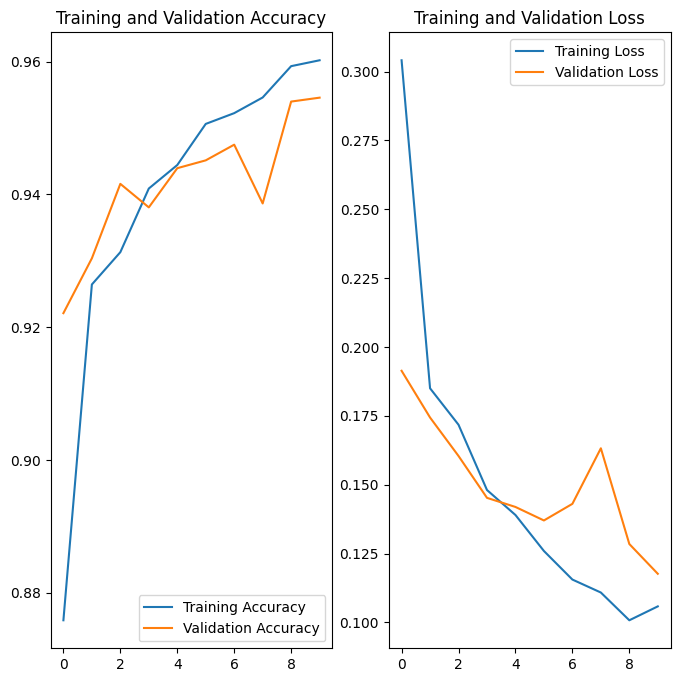

In [ ]:
acc = rhistory.history['accuracy']
val_acc = rhistory.history['val_accuracy']

loss= rhistory.history['loss']
val_loss= rhistory.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 결과

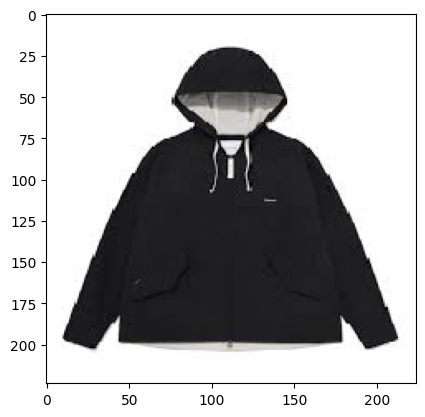

1/1 [==============================] - 0s 25ms/step
This image most likely belongs to 아우터 with a 99.72 percent confidence.


In [ ]:
import numpy as np

sample_url = './sample_image.jpg'

sample_img = load_img(sample_url, target_size=(224,224))
plt.imshow(sample_img)
plt.show()

sample_img.resize((224, 224))
list=[]
list.append(np.array(sample_img))
sample=np.asarray(list)
predict=res_model.predict(sample)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(predict[0])], 100 * np.max(predict[0]))
)